# Preparing

In [119]:
# !nvidia-smi

## Install library

In [120]:
# !pip install --quiet pytorch-lightning==1.2.5
# !pip install --quiet tqdm==4.59.0

## Import libraries

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc, rcParams
import math

import pandas as pd
import numpy as np
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm
import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

4.61.2
1.2.5


In [122]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [123]:
pl.seed_everything(42)

Global seed set to 42


42

# Data

## Loading watch data

In [124]:
watch = pd.read_csv("Datasets\Price_chart_Tang\Rolex 126334\Combine_all.csv")
watch['Date'] = pd.to_datetime(watch['Date'])
watch['Price'] = pd.to_numeric(watch['Price'])
watch.head()

,Date,Price
0,2017-06-09,9575.0
1,2017-06-10,9575.0
2,2017-06-14,9575.0
3,2017-06-23,9575.0
4,2017-06-24,4791.0


In [125]:
watch = watch.resample('D', on='Date', convention='s').mean()
watch['Date'] = watch.index
watch.reset_index(drop=True, inplace=True)

watch.fillna(method='ffill', inplace=True)

print(watch.shape)
watch.head()

(1736, 2)


,Price,Date
0,9575.0,2017-06-09
1,9575.0,2017-06-10
2,9575.0,2017-06-11
3,9575.0,2017-06-12
4,9575.0,2017-06-13


In [126]:
watch["Prev_Price"] = watch.shift(1)["Price"]
watch.head()

,Price,Date,Prev_Price
0,9575.0,2017-06-09,NaN
1,9575.0,2017-06-10,9575.0
2,9575.0,2017-06-11,9575.0
3,9575.0,2017-06-12,9575.0
4,9575.0,2017-06-13,9575.0


In [127]:
# tqdm.pandas()
watch["Price_Change"] = watch.progress_apply(
    lambda row: 0 if np.isnan(row["Prev_Price"]) else row["Price"] - row["Prev_Price"],
    axis = 1
)
watch.head()

  0%|          | 0/1736 [00:00<?, ?it/s]

,Price,Date,Prev_Price,Price_Change
0,9575.0,2017-06-09,NaN,0.0
1,9575.0,2017-06-10,9575.0,0.0
2,9575.0,2017-06-11,9575.0,0.0
3,9575.0,2017-06-12,9575.0,0.0
4,9575.0,2017-06-13,9575.0,0.0


## Loading other data

In [128]:
gold = pd.read_csv("Datasets\Gold_price.csv")
gold['Gold price (USD)'] = gold['Gold price (USD)'].str.replace(',','')
gold['Date'] = pd.to_datetime(gold['Date'], dayfirst=True)
gold['Gold price (USD)'] = pd.to_numeric(gold['Gold price (USD)'])
mask = (gold.Date >= watch.iloc[0]['Date']) & (gold.Date <= watch.iloc[-1]['Date'])
gold = gold.loc[mask]

gold = gold.resample('D', on='Date', convention='s').mean()
gold.fillna(method='ffill', inplace=True)

print(gold.shape)
gold.head()

(1736, 1)


,Gold price (USD)
Date,
2017-06-09,1266.6
2017-06-10,1266.6
2017-06-11,1266.6
2017-06-12,1266.4
2017-06-13,1262.0


## Create feature df

In [129]:
rows = []

for _, row in tqdm(watch.iterrows(), total=watch.shape[0]):
    row_data = dict(
        day_of_week = row.Date.dayofweek,
        day_of_month = row.Date.day,
        week_of_year = row.Date.week,
        month = row.Date.month,
        price_change = row.Price_Change,
        price = row.Price
    )
    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/1736 [00:00<?, ?it/s]

In [130]:
print(features_df.shape)
features_df.head()

(1736, 6)


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,4,9,23,6,0.0,9575.0
1,5,10,23,6,0.0,9575.0
2,6,11,23,6,0.0,9575.0
3,0,12,24,6,0.0,9575.0
4,1,13,24,6,0.0,9575.0


In [131]:
train_size = int(len(features_df) * 0.7)
print(train_size)

1215


In [132]:
train_df, test_df = features_df[:train_size], features_df[train_size:]
print(train_df.shape, test_df.shape)

(1215, 6) (521, 6)


In [133]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_df)

In [134]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [135]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

In [136]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,price_change,price
1215,-0.666667,-0.666667,0.568627,0.636364,0.388881,0.879322
1216,-0.333333,-0.600000,0.568627,0.636364,0.427783,0.923870
1217,0.000000,-0.533333,0.568627,0.636364,0.370300,0.902593
1218,0.333333,-0.466667,0.568627,0.636364,0.388881,0.902593
1219,0.666667,-0.400000,0.568627,0.636364,0.382494,0.895279


In [137]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length):

    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        
        sequences.append((sequence, label))

    return sequences

### Set SEQUENCE_LENGTH and Created sequences

In [138]:
SEQUENCE_LENGTH = 90

train_sequences = create_sequences(train_df, "price", SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, "price", SEQUENCE_LENGTH)

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/431 [00:00<?, ?it/s]

In [139]:
print(f"Sequence shape: {train_sequences[0][0].shape}")
print(f"Train length: {len(train_sequences)}")
print(f"Test length: {len(test_sequences)}")
print(f"Test length: {train_sequences[0][1]}")
train_sequences[0][0].head()

Sequence shape: (90, 6)
Train length: 1125
Test length: 431
Test length: -0.30019946808510634


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,0.333333,-0.466667,-0.137255,-0.090909,0.388881,0.590426
1,0.666667,-0.400000,-0.137255,-0.090909,0.388881,0.590426
2,1.000000,-0.333333,-0.137255,-0.090909,0.388881,0.590426
3,-1.000000,-0.266667,-0.098039,-0.090909,0.388881,0.590426
4,-0.666667,-0.200000,-0.098039,-0.090909,0.388881,0.590426


# Classes create

## Set device

In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("configured device:", device)

configured device: cuda


## TS_Dataset (Time series)

In [141]:
class TS_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device),
            label = torch.tensor(label).float().to(device)
        )

## Price Data Module

In [142]:
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def prepare_data(self):
        self._has_prepared_data = True

    def setup(self):
        self.train_dataset = TS_Dataset(self.train_sequences)
        self.test_dataset = TS_Dataset(self.test_sequences)
        self.prepare_data()
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=4,
            shuffle=False
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False
        )

## Define BATCH_SIZE and N_EPOCHS

In [143]:
N_EPOCHS = 8
BATCH_SIZE = 128

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [144]:
train_dataset = TS_Dataset(train_sequences)

In [145]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([90, 6])
torch.Size([])
tensor(-0.3002, device='cuda:0')


## Price Prediction Model

In [146]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size =n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

## Price Predictor

In [147]:
class PricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features).to(device)
        self.criterion = nn.MSELoss().to(device)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss    

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adagrad(self.parameters(), lr=1e-3)

In [148]:
model = PricePredictor(n_features=train_df.shape[1])

In [149]:
for item in data_module.train_dataloader():
    print(item["sequence"].shape)
    print(item["label"].shape)
    break

torch.Size([128, 90, 6])
torch.Size([128])


# Start Tensorboard

In [150]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17812), started 2 days, 23:00:49 ago. (Use '!kill 17812' to kill it.)

## checkpoint_callback setup

In [151]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="watch-price")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Fit

In [152]:
# trainer.fit(model, data_module)

# Evaluation

## Load trained model

In [153]:
trained_model = PricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint.ckpt",
    n_features=train_df.shape[1]
)

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/THETANG/Documents/GitHub/2-Jan2022/WatchLists/checkpoints/best-checkpoint.ckpt'

In [ ]:
trained_model.freeze()

## Predictions

In [ ]:
test_dataset = TS_Dataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/431 [00:00<?, ?it/s]

In [ ]:
len(predictions), len(test_df)-SEQUENCE_LENGTH

(431, 431)

## Descale

In [ ]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [ ]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

print("Predictions: ", predictions_descaled[:5])
print("Labels: ", labels_descaled[:5])

## Plot graph

In [ ]:
# train_data = watch[:train_size]
test_data = watch[train_size:]
print(test_data.shape)
print(test_df.shape)

(521, 4)
(521, 6)


In [ ]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
print(test_sequences_data.shape)

(431, 4)


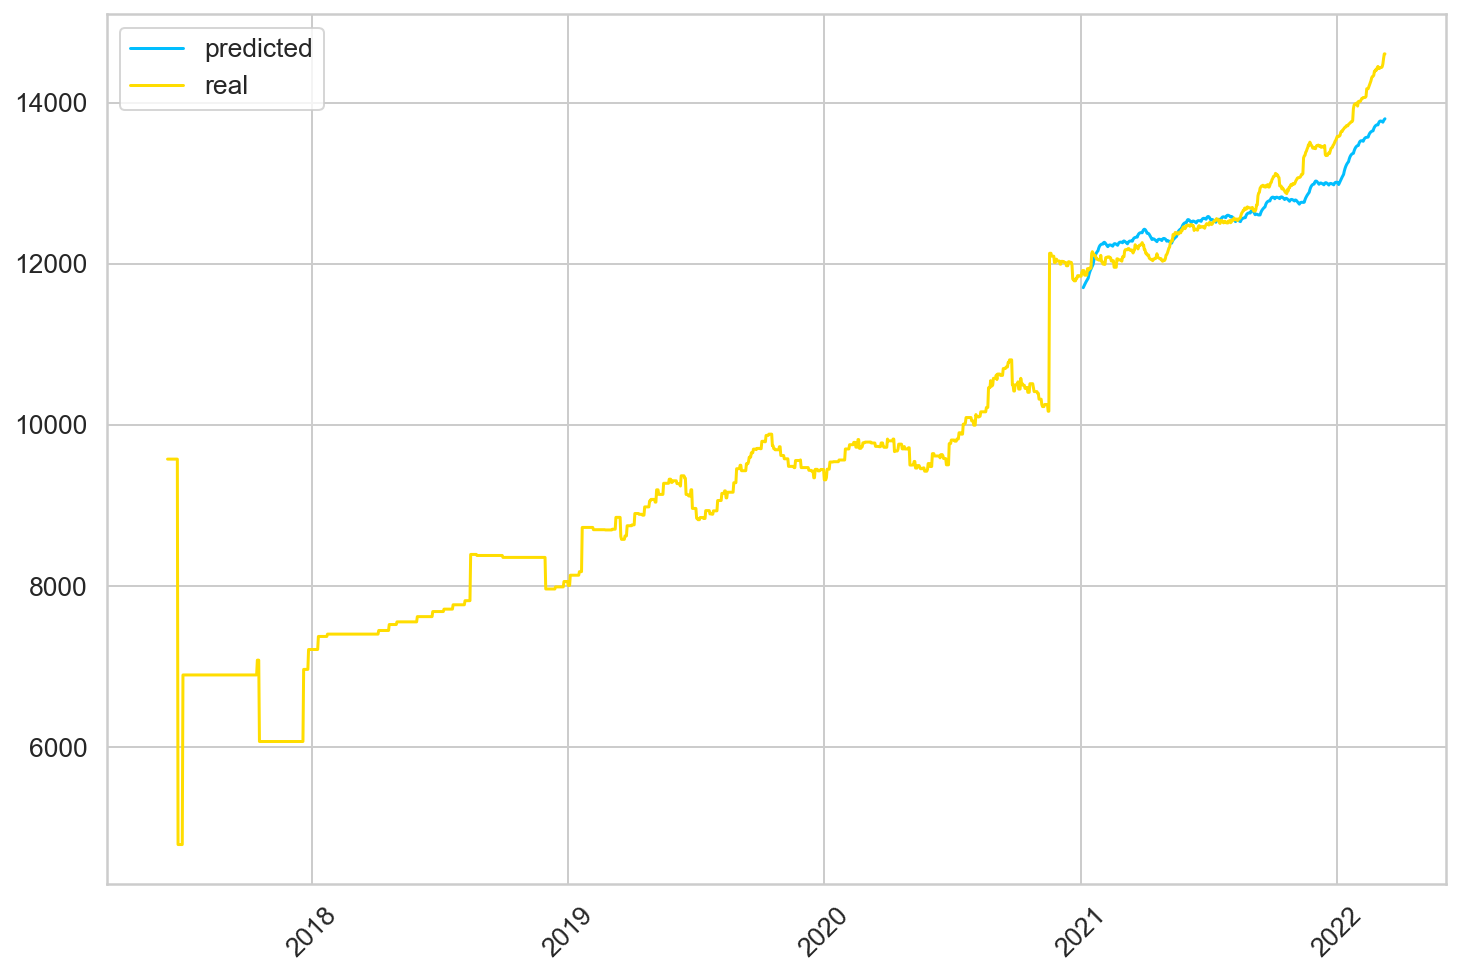

In [ ]:
test_dates = matplotlib.dates.date2num(test_sequences_data.Date.tolist())
all_dates = matplotlib.dates.date2num(watch.Date.tolist())
plt.plot_date(test_dates, predictions_descaled, '-', label='predicted')
# plt.plot_date(test_dates, labels_descaled, '-', label='real')
plt.plot_date(all_dates, watch.Price.tolist(), '-', label='real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evalution function

In [ ]:
# class prediction:
#     def __init__(self, model_path, n_features):
#         self.trained_model = PricePredictor.load_from_checkpoint(
#             model_path,
#             n_features=n_features
#         )
#         self.trained_model.freeze()

#     def get_result(self, sequence, days):
#         _, predictions = trained_model(sequence.unsqueeze(dim=0))
        
